In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [63]:
network = 'tarbase'
network_ppi = 'preppi'
target_homology = 'mix'  # Options: 'wgd', 'ssd', 'mix'

if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.{network_ppi}.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{network_ppi}.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.{network_ppi}.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.{network_ppi}.tsv'
else:
	raise ValueError("target_homology must be 'wdg', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [64]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [65]:
df_wgd = df_1
df_ssd = df_2

In [66]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  137
Number of SSD pairs:  304


In [67]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

df_ssd = df_ssd[
    ~(
        df_ssd["miRNA"].apply(all_clades_in_pre2R)
    )
]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  137
Number of SSD pairs:  99


In [68]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA']

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [69]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  137
Number of SSD pairs after removing miRNA pairs from SSD:  99


In [70]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_delta" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_delta == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_delta'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_delta != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_delta'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [71]:
# remove from bot datasets those rows where the second column is "not_in_G"
df_wgd = df_wgd[df_wgd.iloc[:, 1] != "not_in_G"]
df_ssd = df_ssd[df_ssd.iloc[:, 1] != "not_in_G"]

df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [72]:
df_wgd_ndelta = df_wgd['n_relevant_delta'].astype(int)
df_ssd_ndelta = df_ssd['n_relevant_delta'].astype(int)

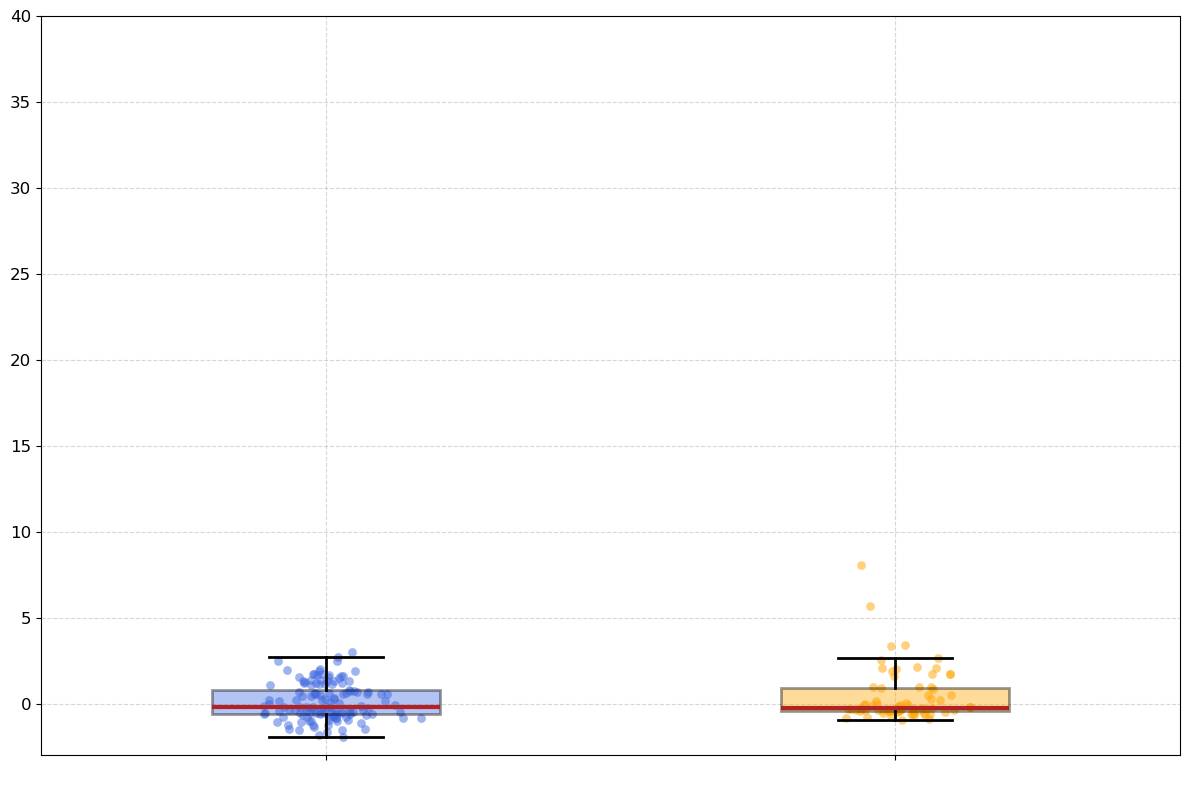

In [73]:
data = [df_wgd_zscores, df_ssd_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.ylim(-3, 40)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{network_ppi}_{target_homology}_delta_boxplot_zscores_mgdbSSD.png', dpi=300)
plt.show()

In [74]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.21593984962406015, p-value: 0.018728503195826543


In [75]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA,n_targets,mu,sigma,n_relevant_delta,n_maj_true,Z-score,pValue (nm size=1000)
64,MIR188,124,0.358,0.611421295016783,2,53,2.6855459784974096,0.005860763348569997
161,MIR374A,230,1.366,1.2751643031390112,4,61,2.0656161668861084,0.1583468424146781
164,MIR376A2,94,0.217,0.4581604522435344,1,199,1.7090082659159715,0.02040022735581326
165,MIR376B,70,0.12,0.34583232931581165,1,114,2.544585700651457,0.00026328373242001657
171,MIR382,149,0.586,0.8164582046865596,2,133,1.7318706479811032,0.1173132314250026
172,MIR409,102,0.245,0.5147572243300719,2,34,3.4093742002048355,0.0001235048053146448
174,MIR411,80,0.152,0.39861761125168566,1,138,2.127352068909409,0.000522467967104312
175,MIR412,211,1.124,1.1465705386063259,5,15,3.380515955617818,0.027550837694464203
176,MIR421,142,0.512,0.7442150226916949,2,102,1.9994221490157045,0.0938647687775459
177,MIR424,560,7.465,3.163664805253553,14,39,2.065642349071886,0.9791917993805426


In [76]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA,n_targets,mu,sigma,n_relevant_delta,n_maj_true,Z-score,pValue (nm size=1000)
95,MIR301B,157,0.322,0.5534582188386039,2,40,3.0318458428915807,0.0003466965495346752


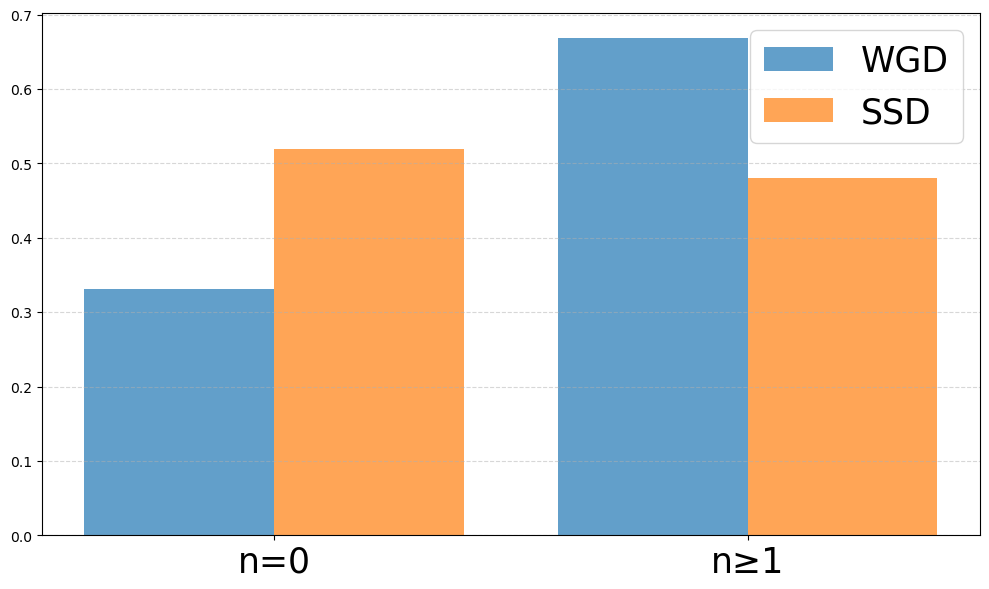

In [77]:
labels = ['n=0', 'n≥1']

def bin_deltas(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_ndelta).apply(bin_deltas)
ssd_binned = pd.Series(df_ssd_ndelta).apply(bin_deltas)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

# Plot
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/{network}_{network_ppi}_{target_homology}_delta_barplot_zscores_mgdbSSD.png', dpi=300)
plt.show()